In [138]:
import os
import sys
import subprocess

REPETITIONS = 5
RESOLUTIONS = ['144', '480', '720', '1080']
ARGS = ['images/video_supercropped_1080.mp4', 'images/video_supercropped_1080edge.mp4', '3', '6', '0.5', '-1', '1', '1', '32', '2']
bins_veri = ['dog', 'dog_flag', 'dog_optimized', 'dog_parallel', 'dog_gpu', 'dog_gpu_pair']

FRAMES_PER_VIDEO = 3

print("Usage: python stats.py <repetitions> <input> <output> <sigma1> <sigma2> <threshold> <max_threads> <bin1> <bin2> ...")


Usage: python stats.py <repetitions> <input> <output> <sigma1> <sigma2> <threshold> <max_threads> <bin1> <bin2> ...


In [88]:

def get_stats(bin_path, threads = -1, xBlock = 32, yBlock = 2):
    # get the output of the executable
    try:
        # with args ARGS
        script_dir = '/home/taulant/CA_Project'
        bin_path = os.path.join(script_dir, bin_path)
        ARGS[0] = os.path.join(script_dir, ARGS[0])
        ARGS[1] = os.path.join(script_dir, ARGS[1])
        ARGS[5] = str(threads)
        ARGS[8] = str(xBlock)
        ARGS[9] = str(yBlock)
        
# Connect via SSH and execute the script
        ssh_command = f"ssh taulant@10.2.86.20 '{bin_path} {' '.join(ARGS)}'"
        try:
            # print(f"Executing {ssh_command}")
            output = subprocess.check_output(ssh_command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            print(f"Error executing {bin_path} via SSH: {e.output.decode()}")
            return None, None, None, None, None
    except subprocess.CalledProcessError as e:
        print(f"Error executing {bin_path}: {e.output.decode()}")
        return None, None, None, None, None
    
    # decode the output
    output = output.decode()
    # parse the output
    lines = output.split('\n')

    cumulative_time = lines[-2].split('\t')



    return cumulative_time



In [26]:
results_parallel

{'480': {'1': {'means': {'read': 0.006330333333333334,
    'grayscale': 0.0028450000000000003,
    'dog': 0.07411066666666667,
    'writer': 0.005411,
    'total': 0.08869666666666666},
   'variances': {'read': 1.9148888888862662e-09,
    'grayscale': 1.006466666666285e-08,
    'dog': 1.3878022222125336e-07,
    'writer': 7.280000000014608e-10,
    'total': 9.722155555787204e-08},
   'std_deviation': {'read': 4.3759443425234125e-05,
    'grayscale': 0.00010032281229442708,
    'dog': 0.0003725321760885271,
    'writer': 2.6981475126491154e-05,
    'total': 0.0003118037131880761}},
  '2': {'means': {'read': 0.006331666666666666,
    'grayscale': 0.002821,
    'dog': 0.042809999999999994,
    'writer': 0.005469666666666667,
    'total': 0.05743299999999999},
   'variances': {'read': 5.75022222222679e-09,
    'grayscale': 1.9686666666646815e-09,
    'dog': 3.5732666667362065e-08,
    'writer': 1.4615555555505836e-09,
    'total': 6.627266666741141e-08},
   'std_deviation': {'read': 7.5830

In [30]:
# stats for all scripts
results = {}

for bin_path in bins_veri:
    results[bin_path] = {}
    for resolution in RESOLUTIONS:
        ARGS[0] = f'images/video_supercropped_{resolution}.mp4'
        ARGS[1] = f'images/video_supercropped_edge_{resolution}.mp4'
        print(f"Running {bin_path}...")
        stat_sums = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}
        stat_squares = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}

        for i in range(REPETITIONS):
            read, grayscale, dog, writer, total = get_stats(bin_path)
            if total:
                stat_sums['read'] += float(read)
                stat_sums['grayscale'] += float(grayscale)
                stat_sums['dog'] += float(dog)
                stat_sums['writer'] += float(writer)
                stat_sums['total'] += float(total)

                stat_squares['read'] += float(read) ** 2
                stat_squares['grayscale'] += float(grayscale) ** 2
                stat_squares['dog'] += float(dog) ** 2
                stat_squares['writer'] += float(writer) ** 2
                stat_squares['total'] += float(total) ** 2

                print(f"Iteration {i + 1} for {bin_path}: read: {read}, grayscale: {grayscale}, dog: {dog}, writer: {writer}, total: {total}")

        variances = {
            stat: ((stat_squares[stat] / REPETITIONS) - (stat_sums[stat] / REPETITIONS) ** 2 )
            for stat in stat_sums
        }
        std_deviation = {
            stat: variances[stat] ** 0.5 / FRAMES_PER_VIDEO
            for stat in variances
        }
        means = {
            stat: stat_sums[stat] / REPETITIONS / FRAMES_PER_VIDEO
            for stat in stat_sums
        }

        

        results[bin_path][resolution] ={
            'means': means,
            'variances': variances,
            'std_deviation': std_deviation
        }
        
        print(f"Results for {bin_path}:")
        for stat in means:
            print(f"  {stat}: {means[stat]} ± {std_deviation[stat]} (variance: {variances[stat]})")

Running dog...
Iteration 1 for dog: read: 0.001609, grayscale: 0.000000, dog: 0.203274, writer: 0.000728, total: 0.205611
Iteration 2 for dog: read: 0.001642, grayscale: 0.000000, dog: 0.202910, writer: 0.000720, total: 0.205273
Iteration 3 for dog: read: 0.001586, grayscale: 0.000000, dog: 0.203140, writer: 0.000722, total: 0.205449
Results for dog:
  read: 0.0005374444444444444 ± 7.661028522634372e-06 (variance: 5.282222222215565e-10)
  grayscale: 0.0 ± 0.0 (variance: 0.0)
  dog: 0.06770266666666666 ± 5.010507479211369e-05 (variance: 2.259466667930976e-08)
  writer: 0.0002411111111111111 ± 1.133115447465129e-06 (variance: 1.1555555555556894e-11)
  total: 0.06848144444444444 ± 4.6009124161979044e-05 (variance: 1.9051555555371635e-08)
Running dog...
Iteration 1 for dog: read: 0.009379, grayscale: 0.000000, dog: 2.260372, writer: 0.005261, total: 2.275013
Iteration 2 for dog: read: 0.009397, grayscale: 0.000000, dog: 2.260193, writer: 0.005225, total: 2.274815
Iteration 3 for dog: read:

In [ ]:
# NON ESEGUIRE PIU'
# Update results by dividing mean times and variances by FRAMES_PER_VIDEO
for bin_key, resolutions in results.items():
    for resolution_key, stats in resolutions.items():
        stats['means'] = {key: value / FRAMES_PER_VIDEO for key, value in stats['means'].items()}
        stats['variances'] = {key: value / FRAMES_PER_VIDEO**2 for key, value in stats['variances'].items()}
        stats['std_deviation'] = {key: value / FRAMES_PER_VIDEO for key, value in stats['std_deviation'].items()}


{'read': [0.0005027777777777779, 0.0020963333333333333, 0.004020222222222222, 0.008924888888888888], 'grayscale': [3.933333333333333e-05, 0.0009149999999999999, 0.001021, 0.0014412222222222222], 'dog': [0.06784544444444444, 0.7544050000000001, 1.6950925555555558, 3.9118581111111106], 'writer': [0.00023777777777777775, 0.0017024444444444446, 0.0023586666666666665, 0.0047977777777777775]}
{'read': [5.971123930011518e-06, 1.8603066254621548e-05, 5.2737177366109145e-05, 0.00011740948707118051], 'grayscale': [5.8878405775519105e-06, 1.7444090583817026e-05, 3.0351032687291118e-05, 4.8630377134534126e-05], 'dog': [0.00015239625088852494, 0.000641477980808512, 8.489484810216478e-05, 0.1282936144126515], 'writer': [1.2272623352455887e-06, 8.438594464903797e-06, 1.3049762308025458e-05, 0.0006605576955390066]}


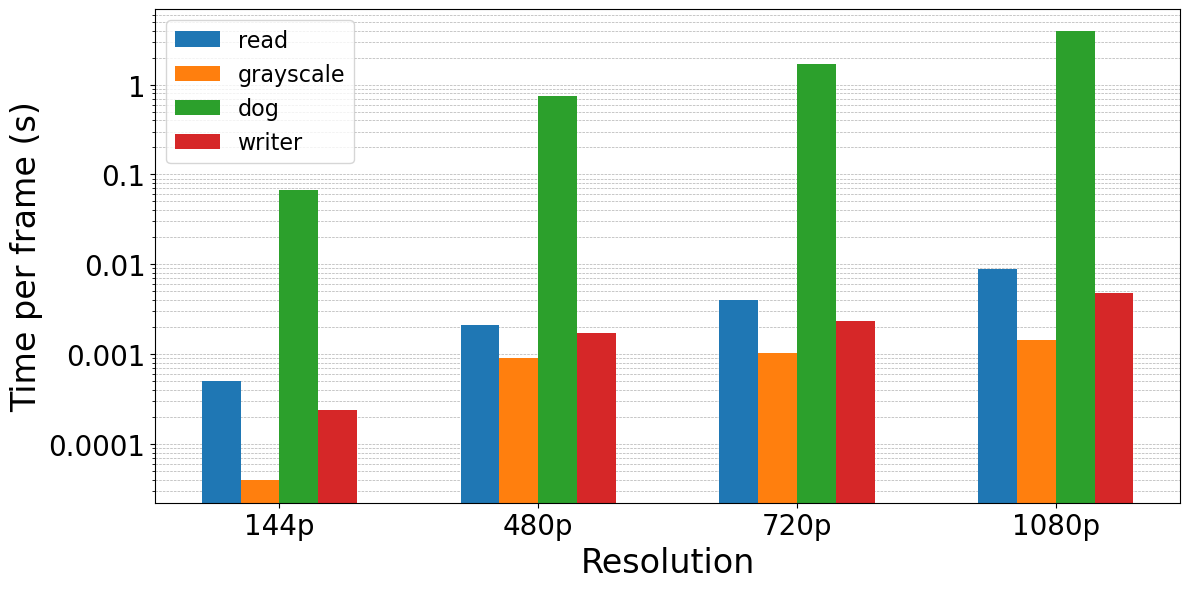

In [41]:
#single bin 
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())
categories = ['read', 'grayscale', 'dog', 'writer', 'total'][:-1]  # Exclude 'total' for individual bar plots


# Reorder bins for plotting
bins = ['dog', 'dog_optimized', 'dog_parallel', 'dog_gpu']
bins = ['dog_gpu']

bins = RESOLUTIONS

single_bin_results = results['dog']

# Prepare data for means and confidence intervals
means = {category: [single_bin_results[bin]['means'][category] for bin in bins] for category in categories}
std_devs = {category: [single_bin_results[bin]['std_deviation'][category] for bin in bins] for category in categories}

print(means)
print(std_devs)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each category
for i, category in enumerate(categories):
    ax.bar(x + i * width, means[category], width, label=category)

# Add labels, title, and legend
#ax.set_xlabel('Bins')
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
# ax.set_title('Execution Time')
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in bins], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))


ax.legend(fontsize=16)
# Export the plot as an SVG
#fig.savefig('/tmp/execution_time_plot_log.svg', format='svg')
# Automatically adjust the borders to prevent the image from being cut off
plt.tight_layout(pad=3.0)
fig.savefig('/tmp/execution_time_plot_log.svg', format='svg')
# Show plot
plt.tight_layout()
plt.show()



{'dog': [0.06784544444444444, 0.7544050000000001, 1.6950925555555558, 3.9118581111111106]}
{'dog': [0.00015239625088852494, 0.000641477980808512, 8.489484810216478e-05, 0.1282936144126515]}
Plot exported as execution_time_plot.svg


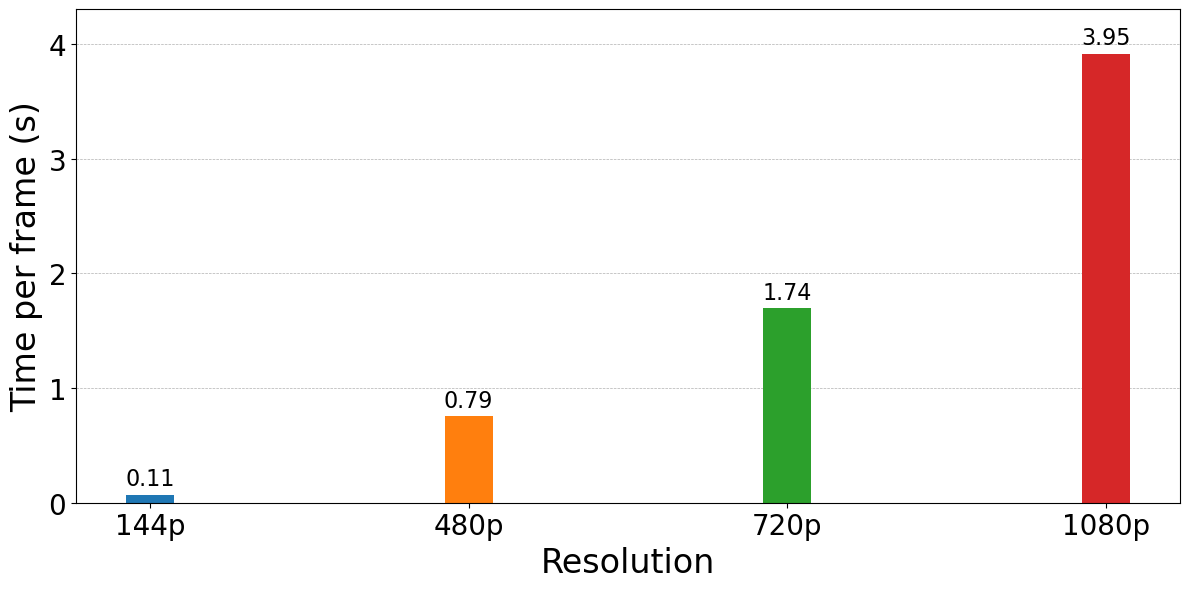

In [5]:
#single bin  DA BUTTARE
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())
categories = ['dog']  # Exclude 'total' for individual bar plots

# Reorder bins for plotting
bins = ['dog', 'dog_optimized', 'dog_parallel', 'dog_gpu']
bins = ['dog_gpu']

bins = RESOLUTIONS

single_bin_results = results['dog']

# Prepare data for means and confidence intervals
means = {category: [single_bin_results[bin]['means'][category] for bin in bins] for category in categories}
std_devs = {category: [single_bin_results[bin]['std_deviation'][category] for bin in bins] for category in categories}

print(means)
print(std_devs)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each category
colors = ['blue', 'green', 'red', 'purple']  # Define a list of colors for each bin
for i, category in enumerate(categories):
    bars = ax.bar(x + i * width, means[category], width, label=category, color=plt.cm.tab10.colors[:len(bins)])
    for bar in bars:
        height = bar.get_height()+0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=16)

# Add labels, title, and legend
#ax.set_xlabel('Bins')
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
# ax.set_title('Execution Time')
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in bins], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
#ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylim(top=max(height * 1.1 for height in means['dog']))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

plt.tight_layout(pad=3.0)

fig.savefig('/tmp/execution_time_plot_lineare.svg', format='svg')
print("Plot exported as execution_time_plot.svg")

# Show plot
plt.tight_layout()
plt.show()



Plot saved as dog_mean_time_plot.svg


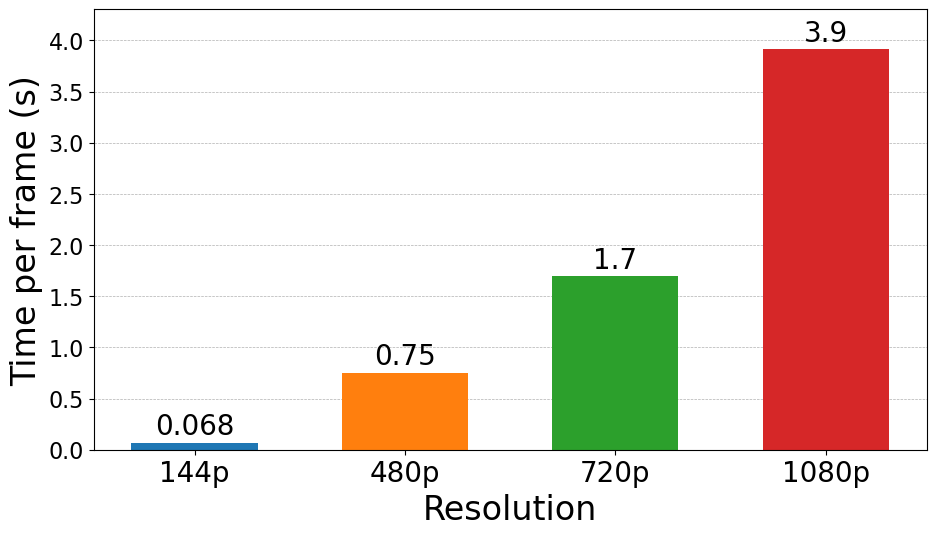

In [60]:
import numpy as np

import matplotlib.pyplot as plt

# Extract mean times for 'dog' across different resolutions
resolutions = RESOLUTIONS
dog_means = [results['dog'][res]['means']['dog'] for res in resolutions]

# Plotting
x = np.arange(len(resolutions))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, dog_means, width, label='Dog', color=plt.cm.tab10.colors[:len(dog_means)])

# Add labels and values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2g}', 
            ha='center', va='bottom', fontsize=20)

# Add labels, title, and legend
ax.set_axisbelow(True)  # Ensure grid lines are below the bars
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
#ax.set_title('Mean Time for Dog vs Resolutions', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels([f"{res}p" for res in resolutions], fontsize=20)
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.set_ylim(top=max(dog_means) * 1.1)  # Set y-axis limit to 10% above the max mean time
ax.tick_params(axis='y', labelsize=16)

#add pad
plt.tight_layout(pad=3.0)

# Save the plot as an SVG file
fig.savefig('/tmp/dog_mean_time_plot.svg', format='svg')
print("Plot saved as dog_mean_time_plot.svg")

# Show plot
plt.show()

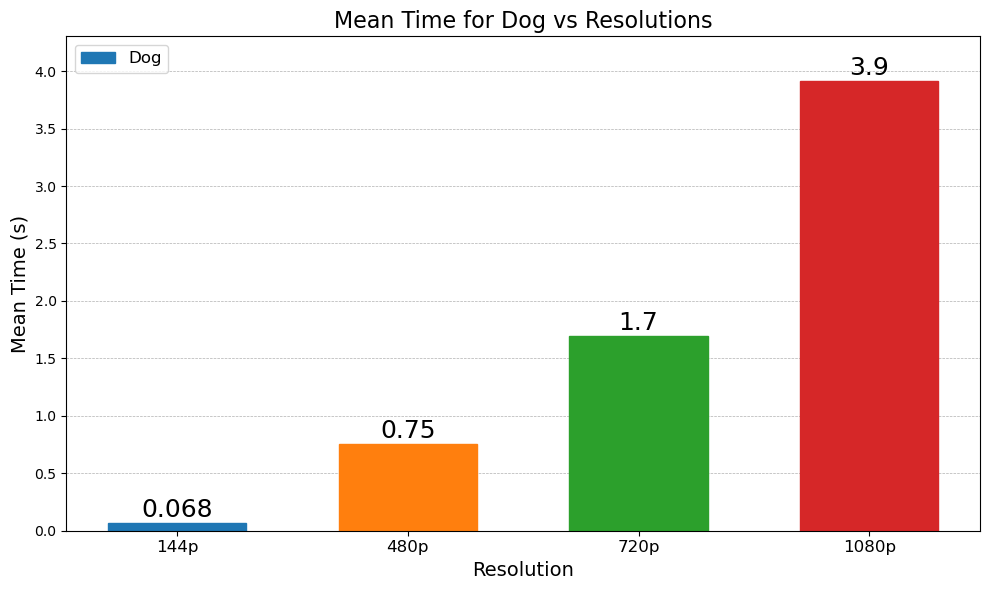

In [59]:
import numpy as np

import matplotlib.pyplot as plt

# Extract mean times for 'dog' across different resolutions
resolutions = RESOLUTIONS
dog_means = [results['dog'][res]['means']['dog'] for res in resolutions]

# Plotting
x = np.arange(len(resolutions))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, dog_means, width, label='Dog', color='blue')

# Add labels and values on top of bars
colors = plt.cm.tab10.colors  # Use a standard color palette

for bar, color in zip(bars, colors):
    bar.set_color(color)
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2g}', 
            ha='center', va='bottom', fontsize=18)
    
# Add labels, title, and legend
ax.set_axisbelow(True)  # Ensure grid lines are below the bars
ax.set_ylabel('Mean Time (s)', fontsize=14)
ax.set_xlabel('Resolution', fontsize=14)
ax.set_title('Mean Time for Dog vs Resolutions', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([f"{res}p" for res in resolutions], fontsize=12)
ax.set_ylim(bottom=0, top=max(dog_means) * 1.1)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

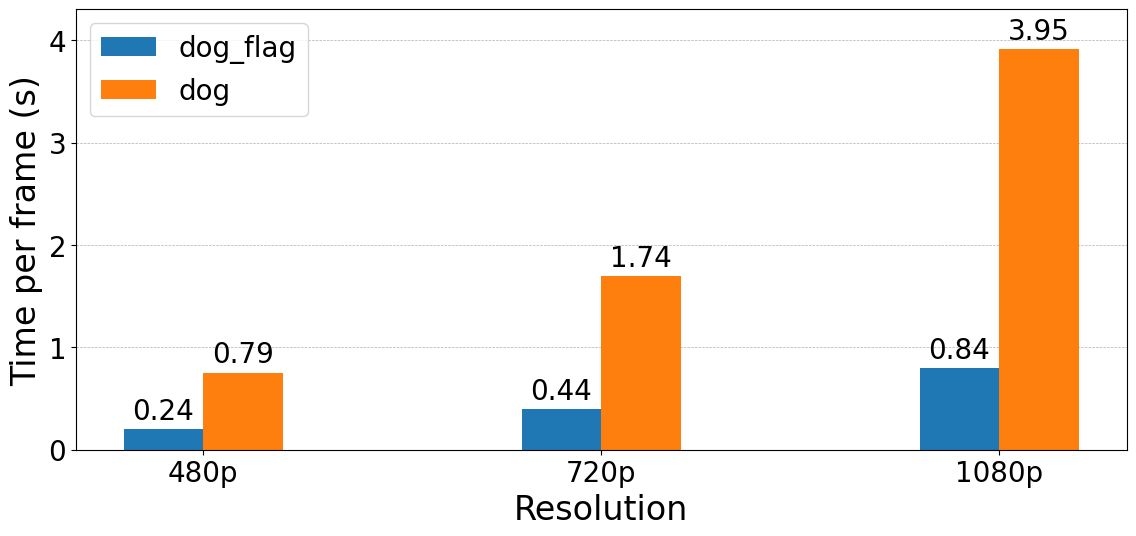

In [18]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())

bins = ['dog_flag', 'dog']
res = RESOLUTIONS[1:]

# Prepare data for means and confidence intervals for each bin and resolution
means = {bin_key: [results[bin_key][resolution]['means']['dog'] for resolution in res] for bin_key in bins}
std_devs = {bin_key: [results[bin_key][resolution]['std_deviation']['dog'] for resolution in res] for bin_key in bins}



# Plotting
x = np.arange(len(res))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each bin
for i, bin_key in enumerate(bins):
    bars = ax.bar(x + i * width, means[bin_key], width, label=bin_key)
    for bar in bars:
        height = bar.get_height()+0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=20)

# Add labels, title, and legend
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
ax.set_xticks(x + width * (len(bins) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in res], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=20)
ax.set_ylim(bottom=0, top=max(height * 1.1 for height in means['dog']))
# Automatically adjust the borders to prevent the image from being cut off
plt.tight_layout(pad=3.0)

fig.savefig('/tmp/execution_time_plot_dog_flag_vs_dog.svg', format='svg')

# Show plot
plt.show()



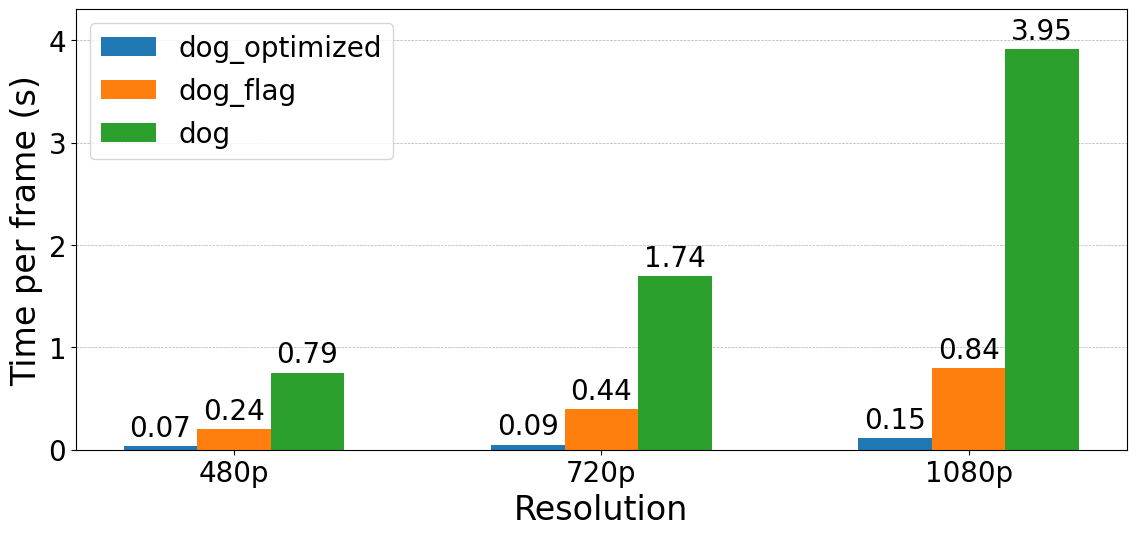

In [20]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())

bins = ['dog_optimized', 'dog_flag', 'dog']
res = RESOLUTIONS[1:]

# Prepare data for means and confidence intervals for each bin and resolution
means = {bin_key: [results[bin_key][resolution]['means']['dog'] for resolution in res] for bin_key in bins}
std_devs = {bin_key: [results[bin_key][resolution]['std_deviation']['dog'] for resolution in res] for bin_key in bins}



# Plotting
x = np.arange(len(res))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each bin
for i, bin_key in enumerate(bins):
    bars = ax.bar(x + i * width, means[bin_key], width, label=bin_key)
    for bar in bars:
        height = bar.get_height()+0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=20)

# Add labels, title, and legend
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
ax.set_xticks(x + width * (len(bins) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in res], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=20)
ax.set_ylim(bottom=0, top=max(height * 1.1 for height in means['dog']))
# Automatically adjust the borders to prevent the image from being cut off
plt.tight_layout(pad=3.0)

fig.savefig('/tmp/execution_time_plot_dog_optimized_vs_dog_flag_vs_dog.svg', format='svg')

# Show plot
plt.show()



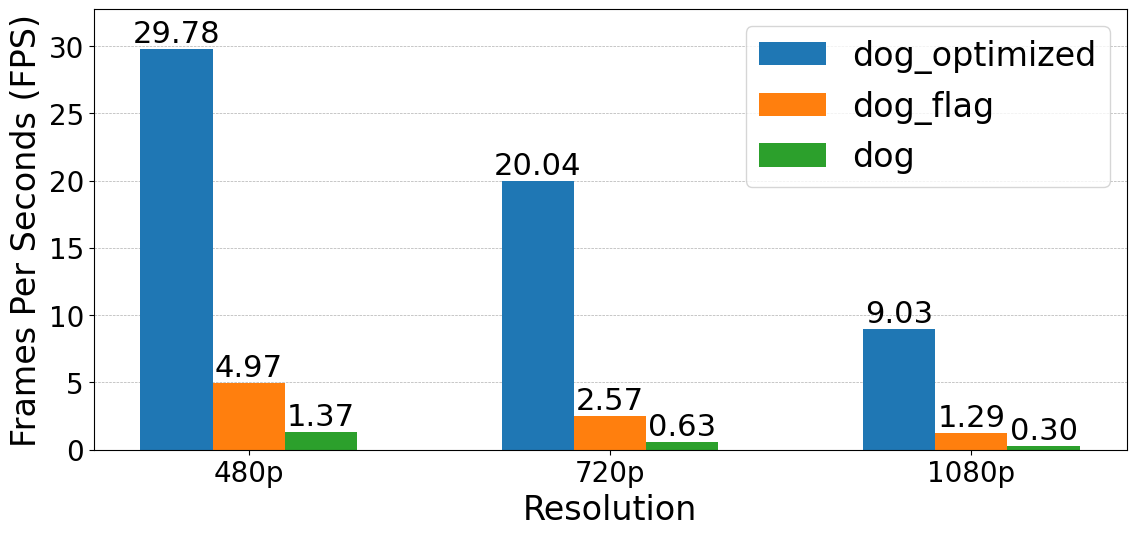

In [134]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())

bins = ['dog_optimized', 'dog_flag', 'dog']
res = RESOLUTIONS[1:]

# Prepare data for means and confidence intervals for each bin and resolution
means = {bin_key: [(1 / results[bin_key][resolution]['means']['dog']) for resolution in res] for bin_key in bins}
#std_devs = {bin_key: [results[bin_key][resolution]['std_deviation']['dog'] for resolution in res] for bin_key in bins}



# Plotting
x = np.arange(len(res))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each bin
for i, bin_key in enumerate(bins):
    bars = ax.bar(x + i * width, means[bin_key], width, label=bin_key)
    for bar in bars:
        height = bar.get_height()+0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=22)

# Add labels, title, and legend
ax.set_ylabel('Frames Per Seconds (FPS)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
ax.set_xticks(x + width * (len(bins) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in res], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=24)
ax.set_ylim(bottom=0, top=max(height * 1.1 for height in means['dog_optimized']))
# Automatically adjust the borders to prevent the image from being cut off
plt.tight_layout(pad=3.0)

fig.savefig('/tmp/execution_time_plot_dog_optimized_vs_dog_flag_vs_dog.svg', format='svg')

# Show plot
plt.show()



{'read': [0.08877666666666667], 'grayscale': [0.021109666666666665], 'dog': [0.049694666666666665], 'writer': [0.08957266666666668]}
{'read': [0.0019338342454530075], 'grayscale': [0.0007019707179711538], 'dog': [0.0013889817213421287], 'writer': [0.002503920437145176]}


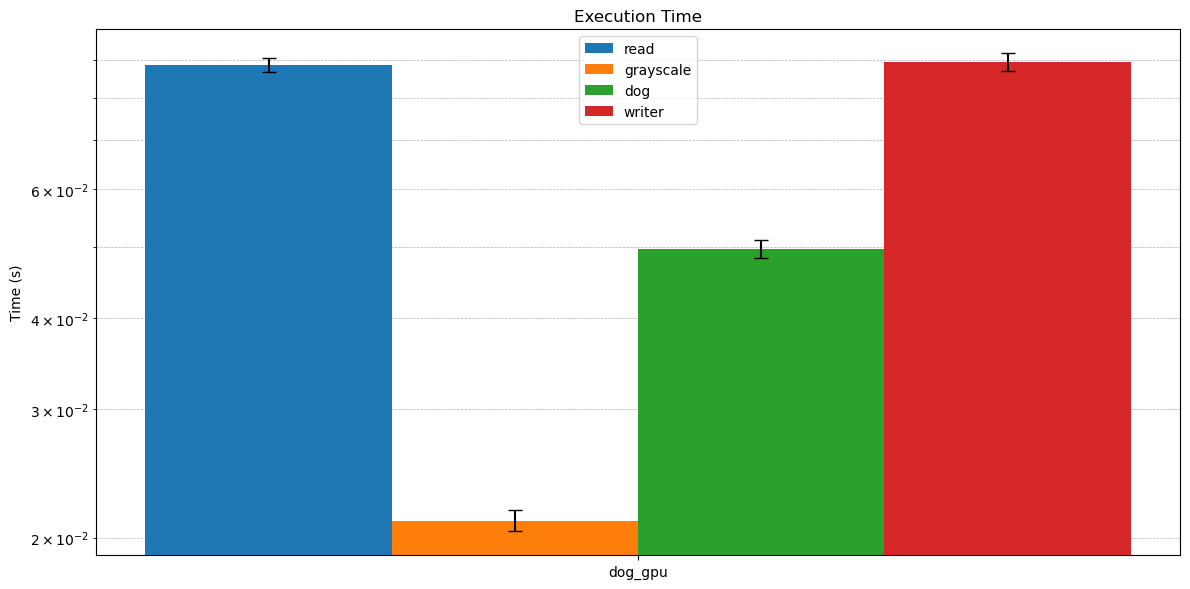

Plot exported as execution_time_plot.pdf


In [20]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())
categories = ['read', 'grayscale', 'dog', 'writer', 'total'][:-1]  # Exclude 'total' for individual bar plots

# Reorder bins for plotting
bins = ['dog', 'dog_optimized', 'dog_parallel', 'dog_gpu']
bins = ['dog_gpu']

# Prepare data for means and confidence intervals
means = {category: [results[bin]['means'][category] for bin in bins] for category in categories}
std_devs = {category: [results[bin]['std_deviation'][category] for bin in bins] for category in categories}

print(means)
print(std_devs)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each category
for i, category in enumerate(categories):
    ax.bar(x + i * width, means[category], width, label=category, yerr=std_devs[category], capsize=5)

# Add labels, title, and legend
#ax.set_xlabel('Bins')
ax.set_ylabel('Time (s)')
ax.set_title('Execution Time')
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels(bins)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

ax.legend()

# Show plot
plt.tight_layout()
plt.show()

# Export the plot as a PDF
with PdfPages('/tmp/execution_time_plot.pdf') as pdf:
    pdf.savefig(fig)
    print("Plot exported as execution_time_plot.pdf")



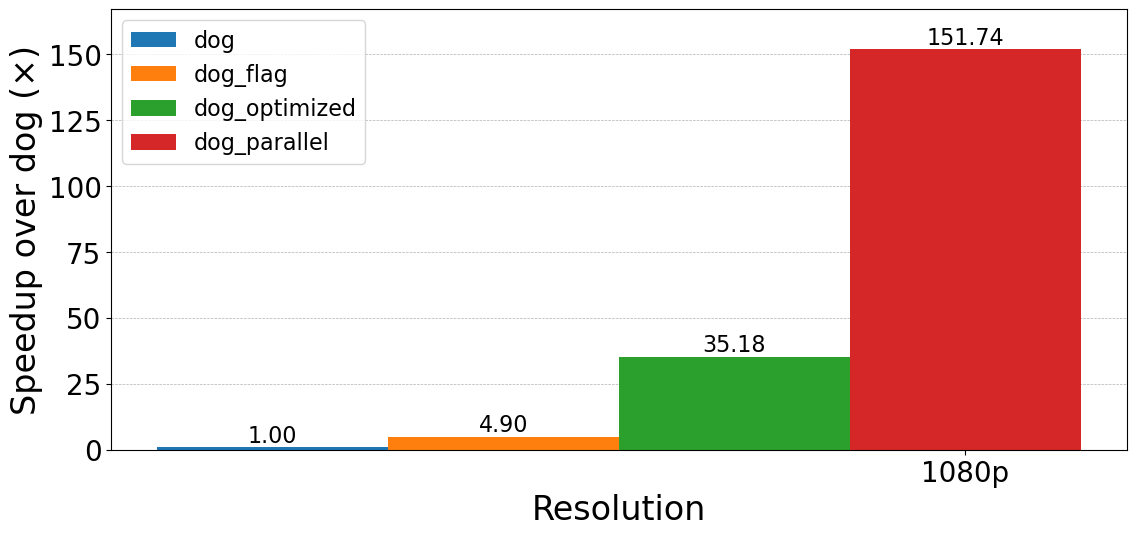

In [6]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Define bins and resolutions
bins = ['dog_parallel', 'dog_optimized', 'dog_flag', 'dog'][::-1]
res = RESOLUTIONS[3:]

# Extract time data
base_times = [results['dog'][r]['means']['dog'] for r in res]

# Compute speedups
speedups = {
    bin_key: [base / results[bin_key][r]['means']['dog'] for base, r in zip(base_times, res)]
    for bin_key in bins
}

# Plotting
x = np.arange(len(res))
width = 0.8 / len(bins)


fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(res))  # one position per resolution
group_width = 0.8
bar_width = group_width / len(bins)

for i, bin_key in enumerate(bins):
    offset = (i - len(bins) / 2) * bar_width + bar_width / 2
    bars = ax.bar(x + offset, speedups[bin_key], bar_width, label=bin_key)

    for bar in bars:
        height = bar.get_height() + 0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{bar.get_height():.2f}', 
                ha='center', va='bottom', fontsize=16)

# Labels, title, and legend
ax.set_ylabel('Speedup over dog (×)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
ax.set_xticks(x + width * (len(bins) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in res], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
ax.legend(fontsize=16)
ax.set_ylim(bottom=0, top=max(max(s) for s in speedups.values()) * 1.1)

plt.tight_layout(pad=3.0)
plt.show()


In [ ]:
# stats for dog_parallel

results_parallel = {}

res = RESOLUTIONS[1:]

bin_path = 'dog_parallel'
for r in res:
    ARGS[0] = f'images/video_supercropped_{r}.mp4'
    ARGS[1] = f'images/video_supercropped_edge_{r}.mp4'
    results_parallel[r] = {}
    for threads in range(1, 13):
        print(f"Running {bin_path}...")
        stat_sums = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}
        stat_squares = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}

        for i in range(REPETITIONS):
            read, grayscale, dog, writer, total = get_stats(bin_path, threads)
            if total:
                stat_sums['read'] += float(read)
                stat_sums['grayscale'] += float(grayscale)
                stat_sums['dog'] += float(dog)
                stat_sums['writer'] += float(writer)
                stat_sums['total'] += float(total)

                stat_squares['read'] += float(read) ** 2
                stat_squares['grayscale'] += float(grayscale) ** 2
                stat_squares['dog'] += float(dog) ** 2
                stat_squares['writer'] += float(writer) ** 2
                stat_squares['total'] += float(total) ** 2

                print(f"Iteration {i + 1} for {r}, threads {threads}: read: {read}, grayscale: {grayscale}, dog: {dog}, writer: {writer}, total: {total}")

        variances = {
            stat: ((stat_squares[stat] / REPETITIONS) - (stat_sums[stat] / REPETITIONS) ** 2) / REPETITIONS
            for stat in stat_sums
        }
        std_deviation = {
            stat: variances[stat] ** 0.5
            for stat in variances
        }
        means = {
            stat: stat_sums[stat] / REPETITIONS / FRAMES_PER_VIDEO
            for stat in stat_sums
        }

        results_parallel[r][threads] = {
            'means': means,
            'variances': variances,
            'std_deviation': std_deviation
        }
        
        print(f"Results for {bin_path}:")
        for stat in means:
            print(f"  {stat}: {means[stat]} ± {std_deviation[stat]} (variance: {variances[stat]})")


Running dog_parallel...
Iteration 1 for 480, threads 1: read: 0.009565, grayscale: 0.000000, dog: 0.073840, writer: 0.005854, total: 0.089258
Iteration 2 for 480, threads 1: read: 0.009509, grayscale: 0.000000, dog: 0.073629, writer: 0.005763, total: 0.088902
Iteration 3 for 480, threads 1: read: 0.009584, grayscale: 0.000000, dog: 0.074499, writer: 0.005774, total: 0.089857
Iteration 4 for 480, threads 1: read: 0.009770, grayscale: 0.000000, dog: 0.074358, writer: 0.005854, total: 0.089982
Iteration 5 for 480, threads 1: read: 0.009198, grayscale: 0.000000, dog: 0.073615, writer: 0.005734, total: 0.088547
Results for dog_parallel:
  read: 0.003175066666666667 ± 8.301585390752346e-05 (variance: 6.891631999995278e-09)
  grayscale: 0.0 ± 0.0 (variance: 0.0)
  dog: 0.02466273333333333 ± 0.0001658836700836969 (variance: 2.751739200043679e-08)
  writer: 0.0019319333333333328 ± 2.204068964443744e-05 (variance: 4.857920000024118e-10)
  total: 0.029769733333333336 ± 0.0002451225652609924 (vari

In [39]:
print(results['dog_parallel']['144']['means']['dog'])

0.0023234444444444444


{'1': {'means': {'read': 0.011432666666666667, 'grayscale': 0.0, 'dog': 0.11659433333333331, 'writer': 0.004884111111111112, 'total': 0.13291122222222224}, 'variances': {'read': 1.1084666666609974e-08, 'grayscale': 0.0, 'dog': 3.3154022222962415e-07, 'writer': 7.446740740729317e-09, 'total': 3.8578607405859167e-07}, 'std_deviation': {'read': 0.00010528374360085215, 'grayscale': 0.0, 'dog': 0.0005757952954215796, 'writer': 8.629450006071834e-05, 'total': 0.0006211167958271549}}, '2': {'means': {'read': 0.011395444444444446, 'grayscale': 0.0, 'dog': 0.06068599999999999, 'writer': 0.005004333333333334, 'total': 0.077086}, 'variances': {'read': 1.3042296296263712e-08, 'grayscale': 0.0, 'dog': 4.929535555609857e-07, 'writer': 3.822222222610074e-11, 'total': 3.5807022222740975e-07}, 'std_deviation': {'read': 0.0001142028734150928, 'grayscale': 0.0, 'dog': 0.0007021065129743391, 'writer': 6.182412330644143e-06, 'total': 0.0005983896909434602}}, '3': {'means': {'read': 0.011399666666666667, 'g

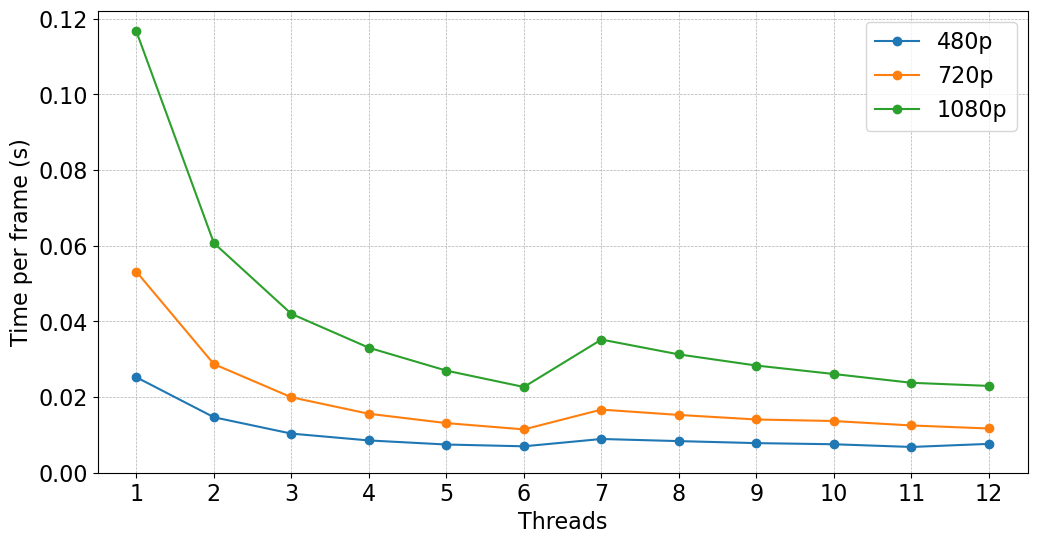

In [47]:
# Extract data for plotting
resolutions = RESOLUTIONS[1:]  # Skip the first resolution if needed
threads = list(range(1, 13))  # Threads from 1 to 12

print(results_parallel['1080'])

# Prepare data for means
means_parallel = {
    resolution: [results_parallel[resolution][str(t)]['means']['dog'] for t in threads] for resolution in resolutions
}

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for resolution in resolutions:
    mean_values = means_parallel[resolution]
    ax.plot(threads, mean_values, marker='o', label=f"{resolution}p")

# Add labels, title, and legend
ax.set_xlabel('Threads', fontsize=16)
ax.set_ylabel('Time per frame (s)', fontsize=16)
#ax.set_title('Execution Time vs Threads for Different Resolutions', fontsize=20)
ax.legend(fontsize=16)
ax.set_xticks(threads)
ax.set_xticklabels([str(t) for t in threads], fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, linestyle='--', linewidth=0.5)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5, right=12.5)

# Export the plot as an SVG
fig.savefig('/tmp/execution_time_vs_threads.svg', format='svg')
print("Plot exported as execution_time_vs_threads.svg")
plt.show()


{'1': {'means': {'read': 0.011432666666666667, 'grayscale': 0.0, 'dog': 0.11659433333333331, 'writer': 0.004884111111111112, 'total': 0.13291122222222224}, 'variances': {'read': 1.1084666666609974e-08, 'grayscale': 0.0, 'dog': 3.3154022222962415e-07, 'writer': 7.446740740729317e-09, 'total': 3.8578607405859167e-07}, 'std_deviation': {'read': 0.00010528374360085215, 'grayscale': 0.0, 'dog': 0.0005757952954215796, 'writer': 8.629450006071834e-05, 'total': 0.0006211167958271549}}, '2': {'means': {'read': 0.011395444444444446, 'grayscale': 0.0, 'dog': 0.06068599999999999, 'writer': 0.005004333333333334, 'total': 0.077086}, 'variances': {'read': 1.3042296296263712e-08, 'grayscale': 0.0, 'dog': 4.929535555609857e-07, 'writer': 3.822222222610074e-11, 'total': 3.5807022222740975e-07}, 'std_deviation': {'read': 0.0001142028734150928, 'grayscale': 0.0, 'dog': 0.0007021065129743391, 'writer': 6.182412330644143e-06, 'total': 0.0005983896909434602}}, '3': {'means': {'read': 0.011399666666666667, 'g

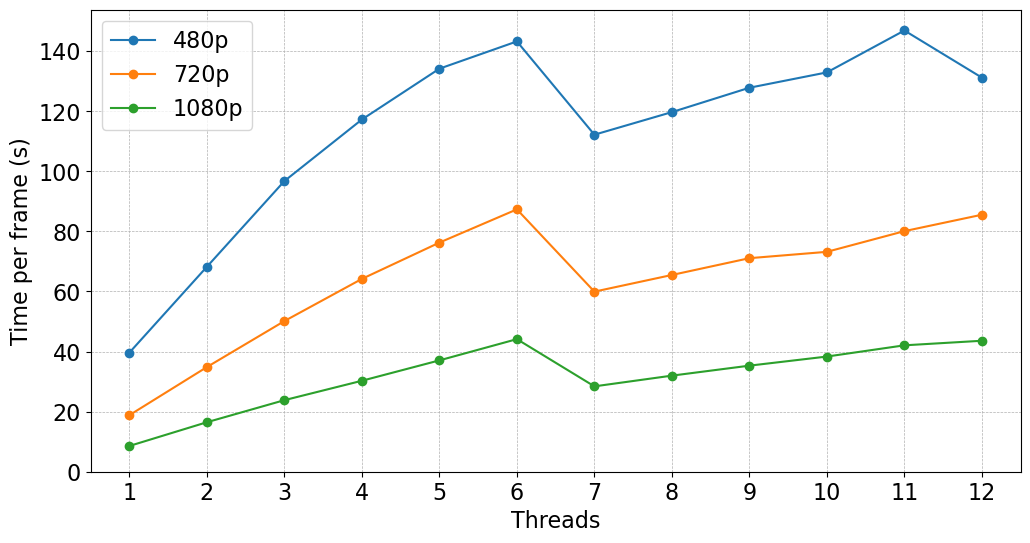

In [135]:
# Extract data for plotting
resolutions = RESOLUTIONS[1:]  # Skip the first resolution if needed
threads = list(range(1, 13))  # Threads from 1 to 12

print(results_parallel['1080'])

# Prepare data for means
means_parallel = {
    resolution: [1 / results_parallel[resolution][str(t)]['means']['dog'] for t in threads] for resolution in resolutions
}

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for resolution in resolutions:
    mean_values = means_parallel[resolution]
    ax.plot(threads, mean_values, marker='o', label=f"{resolution}p")

# Add labels, title, and legend
ax.set_xlabel('Threads', fontsize=16)
ax.set_ylabel('Time per frame (s)', fontsize=16)
#ax.set_title('Execution Time vs Threads for Different Resolutions', fontsize=20)
ax.legend(fontsize=16)
ax.set_xticks(threads)
ax.set_xticklabels([str(t) for t in threads], fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True, linestyle='--', linewidth=0.5)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5, right=12.5)

# Export the plot as an SVG
fig.savefig('/tmp/execution_time_vs_threads.svg', format='svg')
print("Plot exported as execution_time_vs_threads.svg")
plt.show()


In [39]:
# Extract data for plotting
threads = list(results_parallel.keys())
categories = ['dog']

# Prepare data for means and confidence intervals
means_parallel = {category: [results_parallel[t]['means'][category] for t in threads] for category in categories}
std_devs_parallel = {category: [results_parallel[t]['std_deviation'][category] for t in threads] for category in categories}

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for category in categories:
    mean_values = means_parallel[category]
    std_values = std_devs_parallel[category]
    ax.plot(threads, mean_values, label=category)
    ax.fill_between(threads, 
                    [m - s for m, s in zip(mean_values, std_values)], 
                    [m + s for m, s in zip(mean_values, std_values)], 
                    alpha=0.2)

# Remove minor ticks for x-axis
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.minorticks_on()
#ax.xaxis.grid(False, which='minor')
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
#ax.set_xticks(threads)
#ax.set_xticks([t + 0.5 for t in threads[:-1]], minor=True)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5, right=max(threads) + 0.5)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.set_xticks(threads)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
ax.scatter(threads, mean_values, color=ax.lines[-1].get_color(), zorder=5)
ax.set_xlabel('Threads')
ax.set_ylabel('Time (s)')
ax.set_title('Difference of Gaussians Execution Time by Threads')
#ax.set_yscale('log')
#ax.legend()

# Show plot
plt.tight_layout()
plt.show()

KeyError: 'means'

In [45]:
import json

# Export results to a JSON file
with open('results.json', 'w') as results_file:
    json.dump(results, results_file, indent=4)

# Export results_parallel to a JSON file
with open('results_parallel.json', 'w') as results_parallel_file:
    json.dump(results_parallel, results_parallel_file, indent=4)

print("Exported results and results_parallel to JSON files.")

Exported results and results_parallel to JSON files.


In [94]:
import json

# Load results from JSON file
with open('results.json', 'r') as results_file:
    results = json.load(results_file)

# Load results_parallel from JSON file
with open('results_parallel.json', 'r') as results_parallel_file:
    results_parallel = json.load(results_parallel_file)

print("Imported results and results_parallel from JSON files.")

Imported results and results_parallel from JSON files.


{'means': {'read': 0.009024555555555555, 'grayscale': 0.0014446666666666668, 'dog': 0.025779888888888883, 'writer': 0.004624555555555555, 'total': 0.04087377777777777}, 'variances': {'read': 3.527355555560385e-08, 'grayscale': 2.2526666666665917e-09, 'dog': 9.364639355555811e-05, 'writer': 1.5053555555571713e-08, 'total': 9.928288422222584e-05}, 'std_deviation': {'read': 6.260418476925205e-05, 'grayscale': 1.582075523786042e-05, 'dog': 0.0032257022242461342, 'writer': 4.0897643990239985e-05, 'total': 0.003321359899235148}}


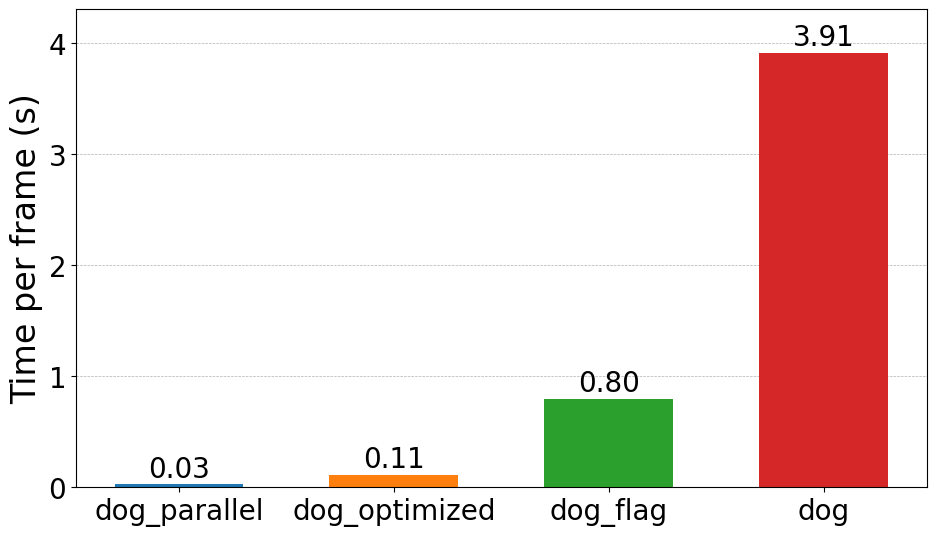

In [58]:
import numpy as np

import matplotlib.pyplot as plt

# Define bins and resolution
bins = ['dog', 'dog_flag', 'dog_optimized', 'dog_parallel'][::-1]
resolution = '1080'

print(results['dog_parallel']['1080'])

# Extract mean times and standard deviations for the specified resolution
means = [results[bin_key][resolution]['means']['dog'] for bin_key in bins]
std_devs = [results[bin_key][resolution]['std_deviation']['dog'] for bin_key in bins]

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Use a standard color palette
bars = ax.bar(x, means, width, color=colors[:len(bins)])

# Add labels and values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=20)

# Add labels, title, and legend
ax.set_axisbelow(True)  # Ensure grid lines are below the bars
ax.set_ylabel('Time per frame (s)', fontsize=24)
#ax.set_xlabel('Bins', fontsize=14)
#ax.set_title(f'Comparison of Execution Times for 1080p', fontsize=16)
ax.set_xticks(x)
ax.set_ylim(bottom=0, top=max(means) * 1.1)
ax.set_xticklabels(bins, fontsize=12)
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)



# Show plot
plt.tight_layout(pad=3.0)
fig.savefig('/tmp/execution_time_plot_1080p.svg', format='svg')
plt.show()

151.74068934009716
35.18230647930336
4.901704506771762
1.0


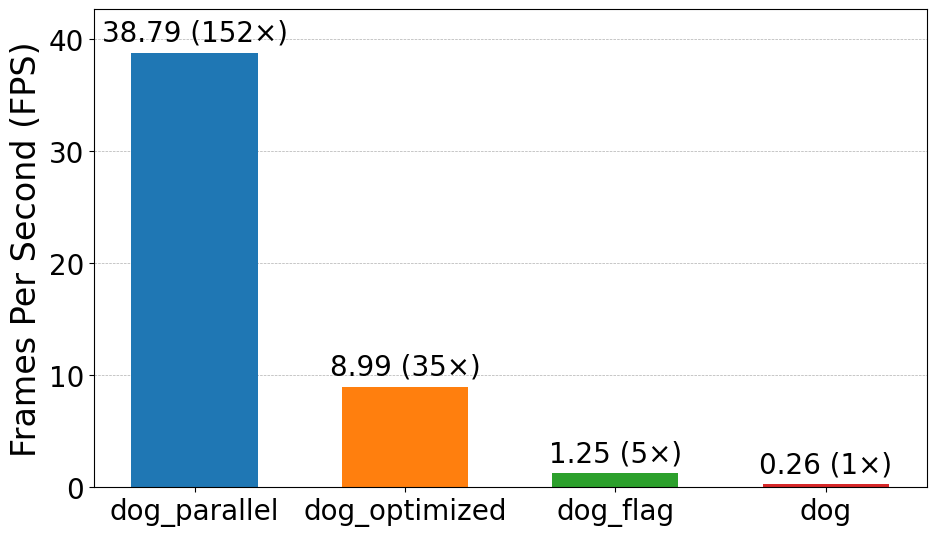

In [77]:
import numpy as np

import matplotlib.pyplot as plt

# Define bins and resolution
bins = ['dog', 'dog_flag', 'dog_optimized', 'dog_parallel'][::-1]
resolution = '1080'

# Calculate FPS for each bin
fps = [1 / results[bin_key][resolution]['means']['dog'] for bin_key in bins]

speedups = [f / fps[-1] for f in fps]  # Speedup compared to the first bin (dog)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, fps, width, color=plt.cm.tab10.colors[:len(bins)])

# Add labels and values on top of bars
i = 0
for bar in bars:
    height = bar.get_height()
    speedup = speedups[i]
    print(speedup)
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{fps[i]:.2f} ({speedup:.0f}×)", 
            ha='center', va='bottom', fontsize=20)
    i += 1

# Add labels, title, and legend
ax.set_axisbelow(True)  # Ensure grid lines are below the bars
ax.set_ylabel('Frames Per Second (FPS)', fontsize=24)
#ax.set_xlabel('Bins', fontsize=14)
#ax.set_title('FPS for 1080p', fontsize=)
ax.set_xticks(x)
ax.set_xticklabels(bins, fontsize=20)
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylim(bottom=0, top=max(fps) * 1.1)

# Show plot
plt.tight_layout(pad=3.0)

fig.savefig('/tmp/fps_plot_1080p.svg', format='svg')

plt.show()

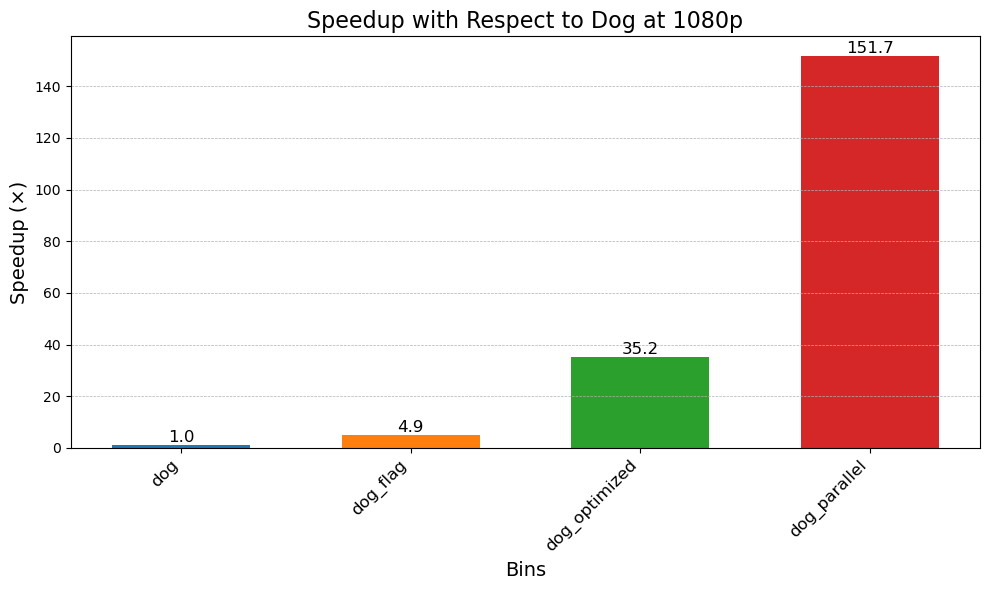

In [38]:
# Filter the bins to include only the desired ones
filtered_bins = ['dog', 'dog_flag', 'dog_optimized', 'dog_parallel']

# Plotting the speedups
x = np.arange(len(filtered_bins))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, [speedups[bin_key] for bin_key in filtered_bins], width, color=colors[:len(filtered_bins)], capsize=5)

# Add labels and values on top of bars
for bar, bin_key in zip(bars, filtered_bins):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}', 
            ha='center', va='bottom', fontsize=12)

# Add labels, title, and legend
ax.set_ylabel('Speedup (×)', fontsize=14)
ax.set_xlabel('Bins', fontsize=14)
ax.set_title('Speedup with Respect to Dog at 1080p', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(filtered_bins, fontsize=12, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

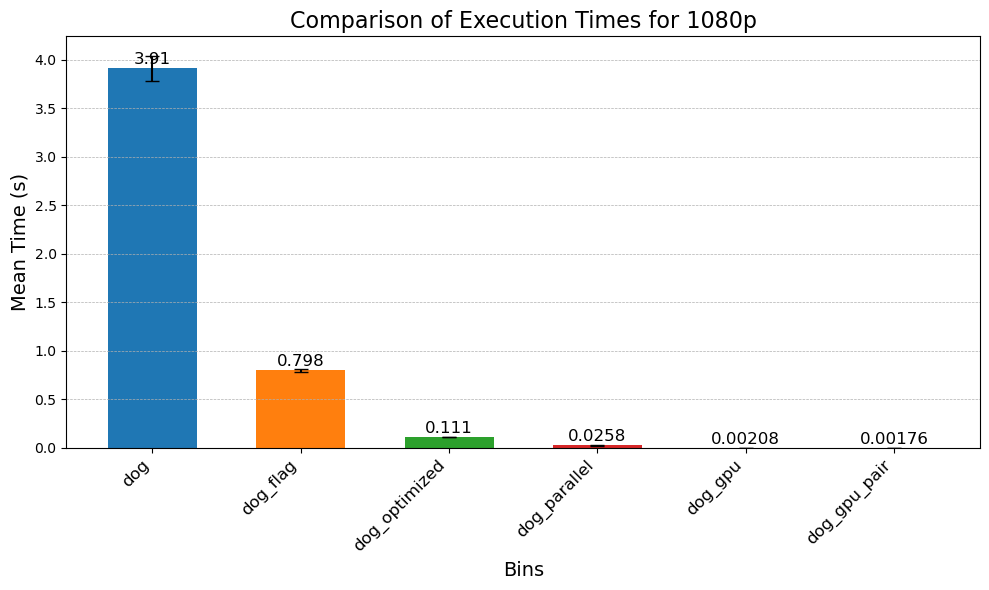

In [102]:
import numpy as np

import matplotlib.pyplot as plt

# Define bins and resolution
bins = bins_veri  # Use all binaries
resolution = '1080'

# Extract mean times and standard deviations for the specified resolution
means = [results[bin_key][resolution]['means']['dog'] for bin_key in bins]
std_devs = [results[bin_key][resolution]['std_deviation']['dog'] for bin_key in bins]

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Use a standard color palette
bars = ax.bar(x, means, width, yerr=std_devs, capsize=5, color=colors[:len(bins)])

# Add labels and values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.3g}', 
            ha='center', va='bottom', fontsize=12)

# Add labels, title, and legend
ax.set_ylabel('Mean Time (s)', fontsize=14)
ax.set_xlabel('Bins', fontsize=14)
ax.set_title(f'Comparison of Execution Times for {resolution}p', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(bins, fontsize=12, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

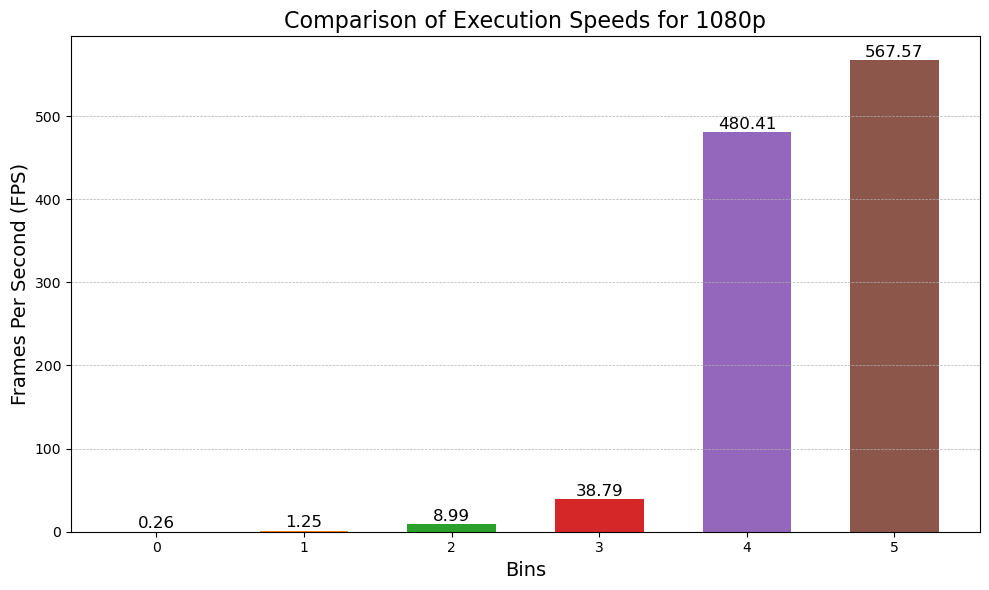

In [84]:
# Calculate frames per second (FPS) for each bin
fps = [1 / mean for mean in means]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
#bars = ax.bar(x, fps, width, yerr=[std / (mean ** 2) for mean, std in zip(means, std_devs)], capsize=5, color=colors[:len(bins)])
bars = ax.bar(x, fps, width, color=colors[:len(bins)])

# Add labels and values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=12)

# Add labels, title, and legend
ax.set_ylabel('Frames Per Second (FPS)', fontsize=14)
ax.set_xlabel('Bins', fontsize=14)
ax.set_title(f'Comparison of Execution Speeds for {resolution}p', fontsize=16)
ax.set_xticks(x)
#ax.set_xticklabels(bins, fontsize=12)
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

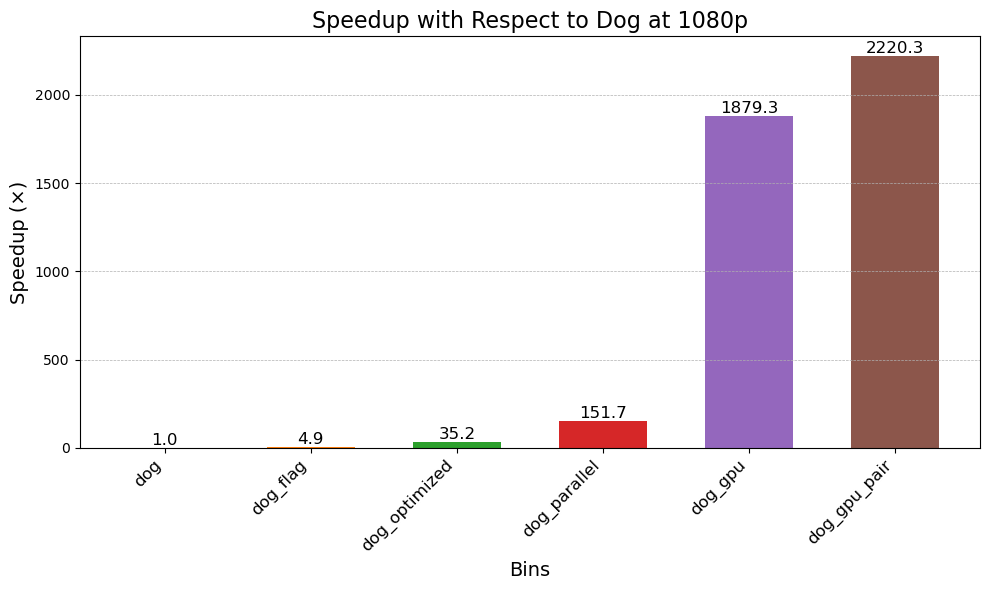

In [85]:
# Calculate speedup with respect to 'dog'
dog_mean_time = results['dog']['1080']['means']['dog']  # Mean time for 'dog' at 1080p
speedups = {bin_key: dog_mean_time / results[bin_key]['1080']['means']['dog'] for bin_key in bins}

# Plotting the speedups
x = np.arange(len(bins))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, speedups.values(), width, color=colors[:len(bins)], capsize=5)

# Add labels and values on top of bars
for bar, bin_key in zip(bars, bins):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.1f}', 
            ha='center', va='bottom', fontsize=12)

# Add labels, title, and legend
ax.set_ylabel('Speedup (×)', fontsize=14)
ax.set_xlabel('Bins', fontsize=14)
ax.set_title('Speedup with Respect to Dog at 1080p', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(bins, fontsize=12, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

In [126]:
# stats for dog_parallel

results_gpu = {}

REPETITIONS = 16
FRAMES_PER_VIDEO = 25

r = '1080'

block_sizes = [(32, 1), (32, 2), (32, 3), (32, 4), (64, 4), (64, 8), (64, 10), (128, 8)]

bin_path = 'dog_gpu'
ARGS[0] = f'images/video_cropped_4k.mp4'
ARGS[1] = f'images/video_supercropped_edge_{r}.mp4'
results_gpu[r] = {}
for block_size in block_sizes:
    print(f"Running {bin_path}...")
    stat_sums = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}
    stat_squares = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}

    for i in range(REPETITIONS):
        read, grayscale, dog, writer, total = get_stats(bin_path, xBlock=block_size[0], yBlock=block_size[1])
        if total:
            stat_sums['read'] += float(read)
            stat_sums['grayscale'] += float(grayscale)
            stat_sums['dog'] += float(dog)
            stat_sums['writer'] += float(writer)
            stat_sums['total'] += float(total)

            stat_squares['read'] += float(read) ** 2
            stat_squares['grayscale'] += float(grayscale) ** 2
            stat_squares['dog'] += float(dog) ** 2
            stat_squares['writer'] += float(writer) ** 2
            stat_squares['total'] += float(total) ** 2

            print(f"Iteration {i + 1} for {r}, threads {block_size}: read: {read}, grayscale: {grayscale}, dog: {dog}, writer: {writer}, total: {total}")

    variances = {
        stat: ((stat_squares[stat] / REPETITIONS) - (stat_sums[stat] / REPETITIONS) ** 2) / REPETITIONS
        for stat in stat_sums
    }
    std_deviation = {
        stat: variances[stat] ** 0.5
        for stat in variances
    }
    means = {
        stat: stat_sums[stat] / REPETITIONS / FRAMES_PER_VIDEO
        for stat in stat_sums
    }

    results_gpu[r][str(block_size[0])+'×'+str(block_size[1])] = {
        'means': means,
        'variances': variances,
        'std_deviation': std_deviation
    }
    
    print(f"Results for {bin_path}:")
    for stat in means:
        print(f"  {stat}: {means[stat]} ± {std_deviation[stat]} (variance: {variances[stat]})")


Running dog_gpu...
Iteration 1 for 1080, threads (32, 1): read: 0.457488, grayscale: 0.000001, dog: 0.235874, writer: 0.443269, total: 1.136632
Iteration 2 for 1080, threads (32, 1): read: 0.447159, grayscale: 0.000001, dog: 0.233478, writer: 0.408452, total: 1.089090
Iteration 3 for 1080, threads (32, 1): read: 0.453727, grayscale: 0.000001, dog: 0.228664, writer: 0.428385, total: 1.110777
Iteration 4 for 1080, threads (32, 1): read: 0.452471, grayscale: 0.000001, dog: 0.233444, writer: 0.426647, total: 1.112563
Iteration 5 for 1080, threads (32, 1): read: 0.449215, grayscale: 0.000001, dog: 0.234226, writer: 0.412681, total: 1.096123
Iteration 6 for 1080, threads (32, 1): read: 0.467987, grayscale: 0.000001, dog: 0.223155, writer: 0.416617, total: 1.107759
Iteration 7 for 1080, threads (32, 1): read: 0.450141, grayscale: 0.000002, dog: 0.234501, writer: 0.409155, total: 1.093800
Iteration 8 for 1080, threads (32, 1): read: 0.458892, grayscale: 0.000001, dog: 0.233030, writer: 0.45183

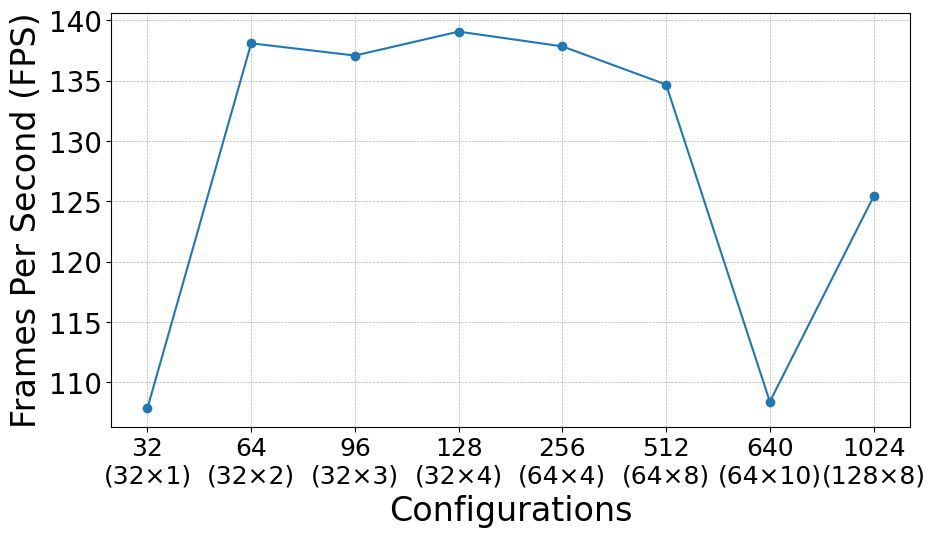

In [127]:
def product(block_size):
    """Format block size for display."""
    return int(block_size.split('×')[0]) * int(block_size.split('×')[1])  # Product of block dimensions for display


# Extract mean dog times for each configuration
configs = list(results_gpu['1080'].keys())
fps_values = [1 / results_gpu['1080'][config]['means']['dog'] for config in configs]

# Plotting
x = np.arange(len(configs))  # the label locations
width = 0.6  # the width of the bars
# Use dots with lines instead of bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, fps_values, marker='o', linestyle='-', label='Mean Dog Time')

# Add labels and values on top of points
#for i, mean_time in enumerate(mean_dog_times):
#    ax.text(x[i], mean_time + 0.001, f'{mean_time:.3g}', ha='center', va='bottom', fontsize=10)
#bars = ax.bar(x, mean_dog_times, width, color=plt.cm.tab10.colors[:len(configs)])

# Add labels and values on top of bars
##for bar in bars:
 #   height = bar.get_height()
  #  ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.3g}', 
   #         ha='center', va='bottom', fontsize=12)

# Add labels, title, and legend
ax.set_ylabel('Frames Per Second (FPS)', fontsize=24)
ax.set_xlabel('Configurations', fontsize=24)
#ax.set_title('Mean Dog Time mean_dog_timesfor Each Configuration at 1080p', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([f"{product(config)}\n({config})" for config in configs], fontsize=18, rotation=0, ha='center')
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.grid(axis='x', linestyle='--', linewidth=0.5)
ax.tick_params(axis='y', labelsize=20)

# Show plot
plt.tight_layout(pad=3.0)
fig.savefig('/tmp/dog_gpu_mean_time_plot.svg', format='svg')
plt.show()